# Emulating the Codecs data for Coupled Dark Energy

## Import Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import time

In [41]:
from looti import dictlearn as dcl
from looti import datahandle as dhl
from looti import PlottingModule as pm
from looti import tools as too
from looti import PlottingModule as pm
#from looti import logOT_bary

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The data is imported from pandas Dataframes which have been previously created using the `read_files` module.
The DataFrames contain the **k-grid** and the **power spectrum** at each redshift and each parameter variation, for the *extended model* and the *reference model*.

# Import Data

The data is imported from pandas Dataframes which have been previously created using the `read_files` module.
The DataFrames contain the **k-grid** and the **power spectrum** at each redshift and each parameter variation, for the *extended model* and the *reference model*.

### Specify Paths

The DataFrames of the *extented model* and the *reference model* should be stored inside the same `data_folder`. The results of the experiments(plots, interpolation functions) are stored inside `the results_folder`

In [4]:
data_folder = '../../SimulationData/Codecs_website/'
results_folder = './results/'

In [5]:
too.mkdirp(results_folder)    ## If directory does not exists, it is created here

### Load CoupledDE dataframes

The user has **two options** : provide the power **spectra** of the *extended* and *reference model* **OR** provide directly the **ratios** between these two models.

**Case 1** (spectra): user provides :
- datafile_ext : filename containing the power spectra of the extended model
- datafile_ref : filename containing the power spectra of the reference model (i.e. LCDM)

**Case 2** (ratios): user provides :
- datafile_ext : filename containing the ratios between the extended model and the reference model

In [6]:
###Name of the file for the external input data, without the extension
datafile_ext = 'Codecs_ext'
###Name of the file for the LCDM input data
datafile_ref = 'Codecs_LCDM'

The following functions load the data into a object `emulation_data`. When the ratios are directly provide the user must indicate : `ratio_mode=True`

In [7]:
## Specify paths and the number of free cosmological parameters to interpolate
emulation_data = dhl.DataHandle( datafile_ext, data_folder, datafile_ref, num_parameters=1) 
emulation_data.read_csv_pandas() 
emulation_data.calculate_ratio_by_redshifts(emulation_data.z_vals)

/local/home/scasas/CosmoProjects/RepresentationLearningInterpolator/looti-test-public/looti/datahandle.py:245: PerformanceWarning: indexing past lexsort depth may impact performance.
  for iind in (self.df_ext.loc[nnoi,z_request].index):


## Calculate power spectra ratios at all redshifts available

Available **redshifts** are stored in the attribute `z_vals`

In [8]:
# Available redshifts
emulation_data.z_vals

array([0.])

The function `calculate_ratio_by_redshifts` computes the ratio between the *extended* and *reference* model at each **redshit** passed as argument.

The user can optionally decide to **normalize** the data by passing `normalize=False`. This option will force all the ratios to be equal to 1 at k = `pos_norm`

In [25]:
## Set normalize=False, since Fitting Formulae are already normalized
## First argument contains all the redshifts at which simulations are available
emulation_data.calculate_ratio_by_redshifts(emulation_data.z_vals,normalize=True)

/local/home/scasas/CosmoProjects/RepresentationLearningInterpolator/looti-test-public/looti/datahandle.py:245: PerformanceWarning: indexing past lexsort depth may impact performance.
  for iind in (self.df_ext.loc[nnoi,z_request].index):


# Define number of training and test

## Choose  the number of training vectors, test vectors and number of data splits

Available parameters are stored in the attribute `emulation_data.extparam_vals`

In [26]:
### Available parameters 
emulation_data.extparam_vals

array([[0.05],
       [0.1 ],
       [0.15]])

The user can choose the number of **training and test vectors** used, the number of splits.

**Indices** of train and tets vectors can also be directly passed. These indices would correspond to the parameters listed above. If no indices are passed for the train vectors they would be randomly set.

In [27]:
n_train = 2 # Number of training vectors without taking acount the extrema 
n_test = 1 # Number of test vectors without taking acount the extrema
n_splits = 1  # Number of splits
test_indices=[[1]]  ## List of list of indices, one list per split

In [28]:
emulation_data.calculate_data_split(n_train=n_train, ##number of training vectors/ redshift
                                    n_test=n_test, ##number of test vectors
                                    verbosity=0,
                                    manual_split=True,
                                    test_indices=test_indices,
                                    train_redshift_indices=[0],##Indices of the redshifts used for the train vect.
                                    test_redshift_indices=[0]) ##Indices of the redshifts used for the test vect.

/local/home/scasas/CosmoProjects/RepresentationLearningInterpolator/looti-test-public/looti/datahandle.py:336: PerformanceWarning: indexing past lexsort depth may impact performance.
  for iind in (self.df_ext.loc[self.noiseless_str,z].index):


# OT with spline interpolation

In [29]:
#emulation_data.data_split(0,thinning=1,verbosity=0);

In [30]:
#OTop=dcl.LearningOperator('OT',interp_type='spl1d', interp_dim = 1 ,nsteps=2, interp_opts={'k':1},xgrids=emulation_data.masked_k_grid)
#OTtest=dcl.LearnData(OTop)
#OTtest.interpolate(emulation_data.matrix_datalearn_dict['theo']['train'],emulation_data.train_samples)
#ratios_predicted= OTtest.predict(emulation_data.test_samples)
#ratios_predicted={tuple(np.array([0.1])):ratios_predicted[0.1]}

The user can access to the train and test samples :

In [31]:
### Train Samples
#emulation_data.train_samples[:,1]

In [32]:
### Test Samples
#emulation_data.test_samples[:,1]

In [33]:
#pm.Plot_prediction_One_parameter(emulation_data, 0.098,ratios_predicted)

In [34]:
#reconstructed_spectra = dcl.reconstruct_spectra(ratios_predicted,emulation_data = emulation_data)
                                            
#pm.Plot_prediction_One_parameter(emulation_data, 0.098 , reconstructed_spectra,
                #                 ratio_mode=False, ## False when the user wants to reconstruct the spectra 
                #                 y_scale_log=True) ## y_scale in log 

The user should provide here the number of PCA components.

# LIN Method

In [136]:
ratios_predicted_LIN , emulation_data = dcl.Predict_ratio(emulation_data,Operator = "LIN", ##choose the operator
                                                      interp_type='int1d',interp_dim=1 ##kind of interpolator,e.g int1d or GP 
                                                     )

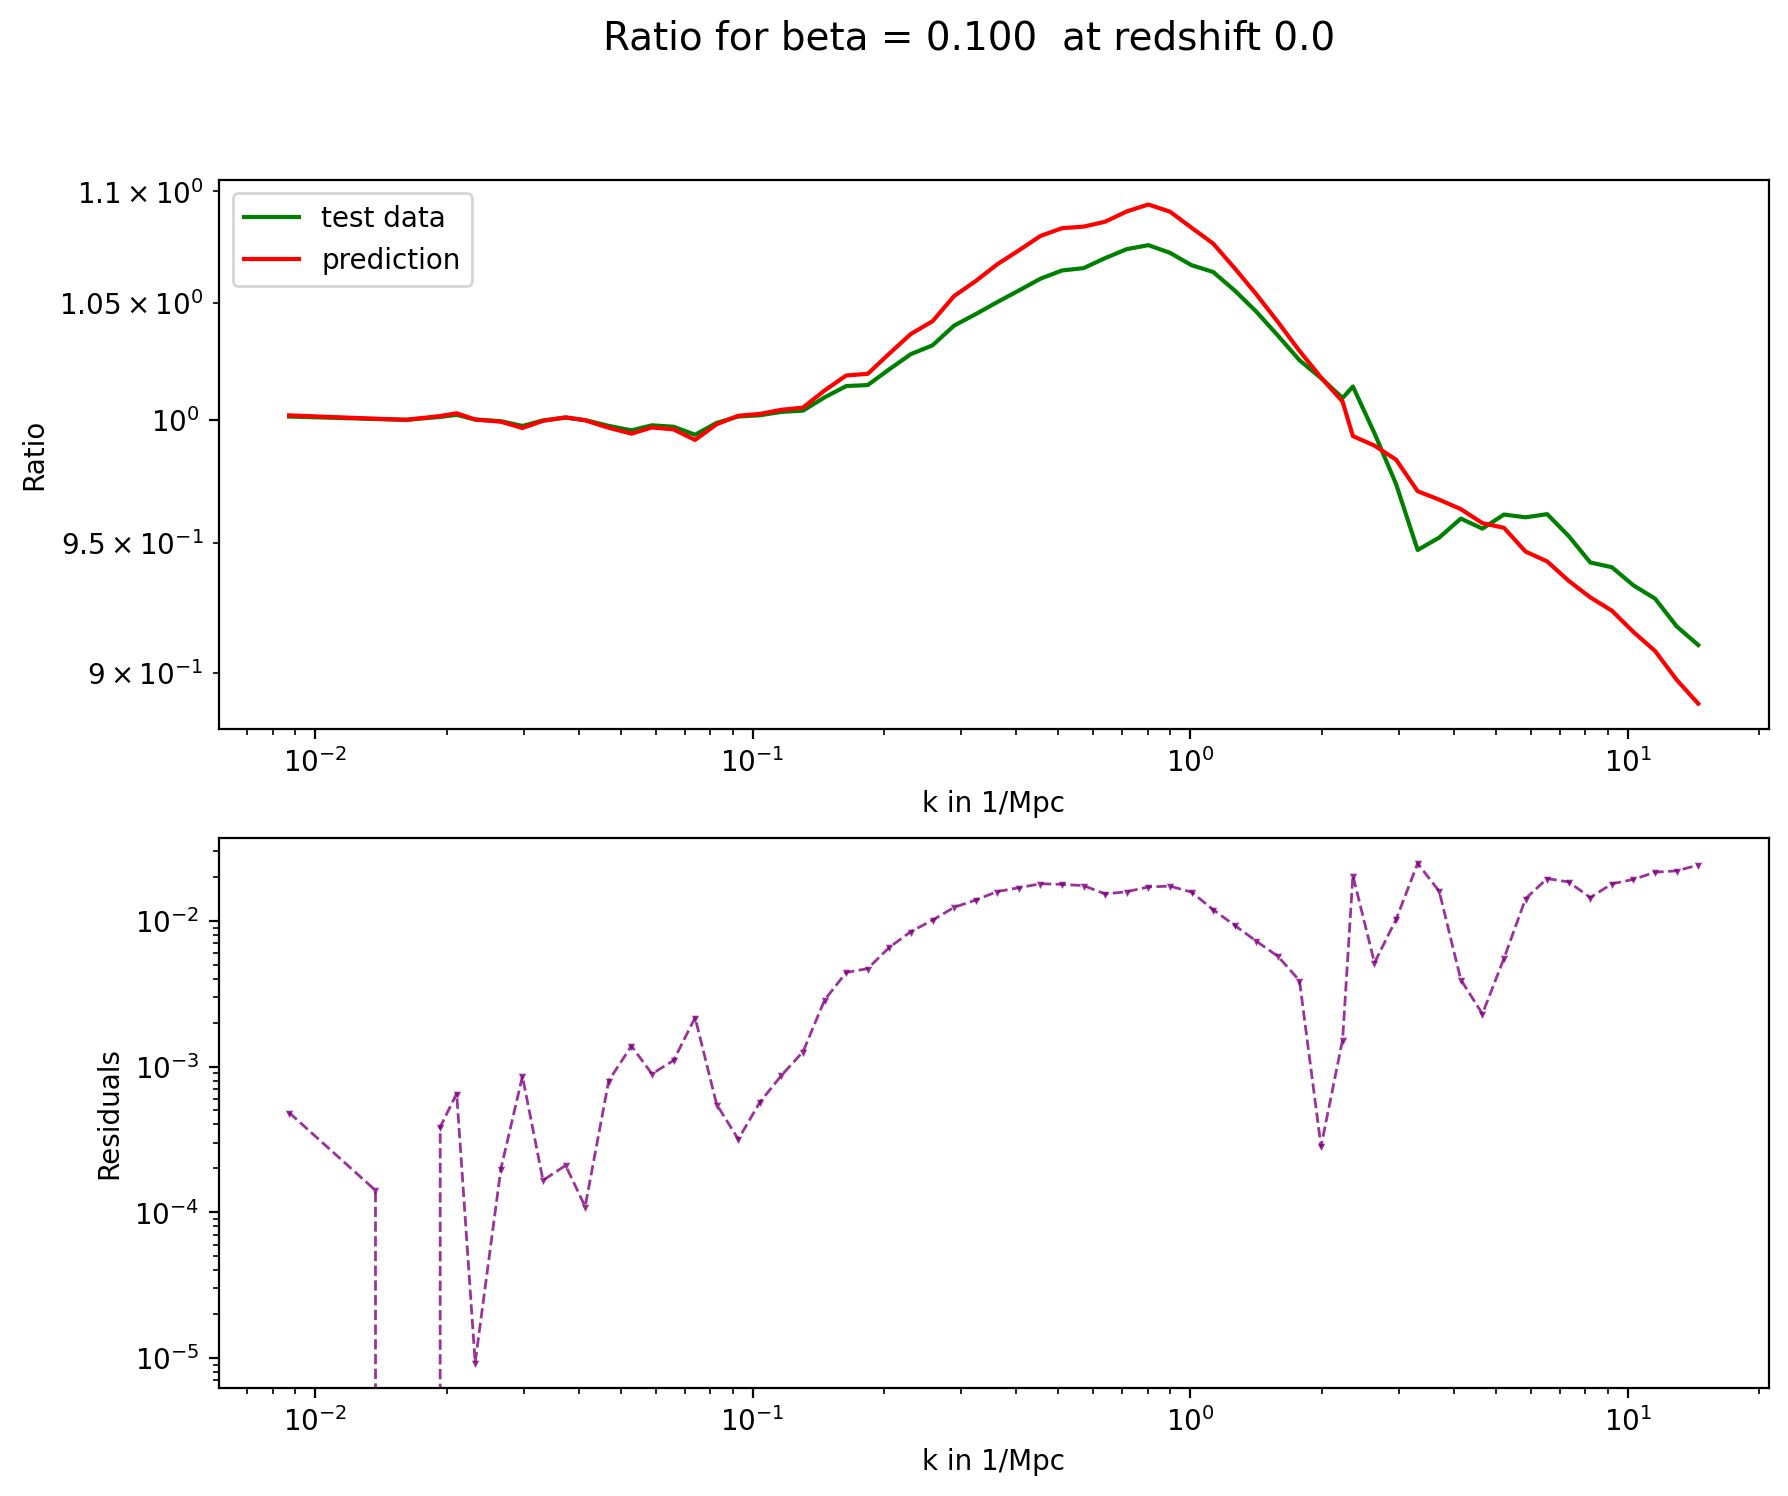

In [143]:
pm.Plot_prediction_One_parameter(emulation_data, 0.1,ratios_predicted_LIN, y_scale_log=True);

# PCA with spline interpolation

The following section performs a **reduction of dimensionality with PCA** and construct the **interpolation with a simple spline**. 

The user should provide here the number of PCA components.

In [138]:
npca = 2 #Number of PCA components.

In [139]:
ratios_predicted_PCAspl , emulation_data = dcl.Predict_ratio(emulation_data,Operator = "PCA", ##choose the operator
                                                      ncomp=npca ,  ##number of components
                                                      interp_type='int1d',interp_dim=1 ##kind of interpolator,e.g int1d or GP 
                                                     )

('Shape of PCA matrix: (2, 2)',)
('Number of PCA components: 2',)


As an example, the predicted ratio of a test vector and its residuals respect to the 'true value' can be plotted.

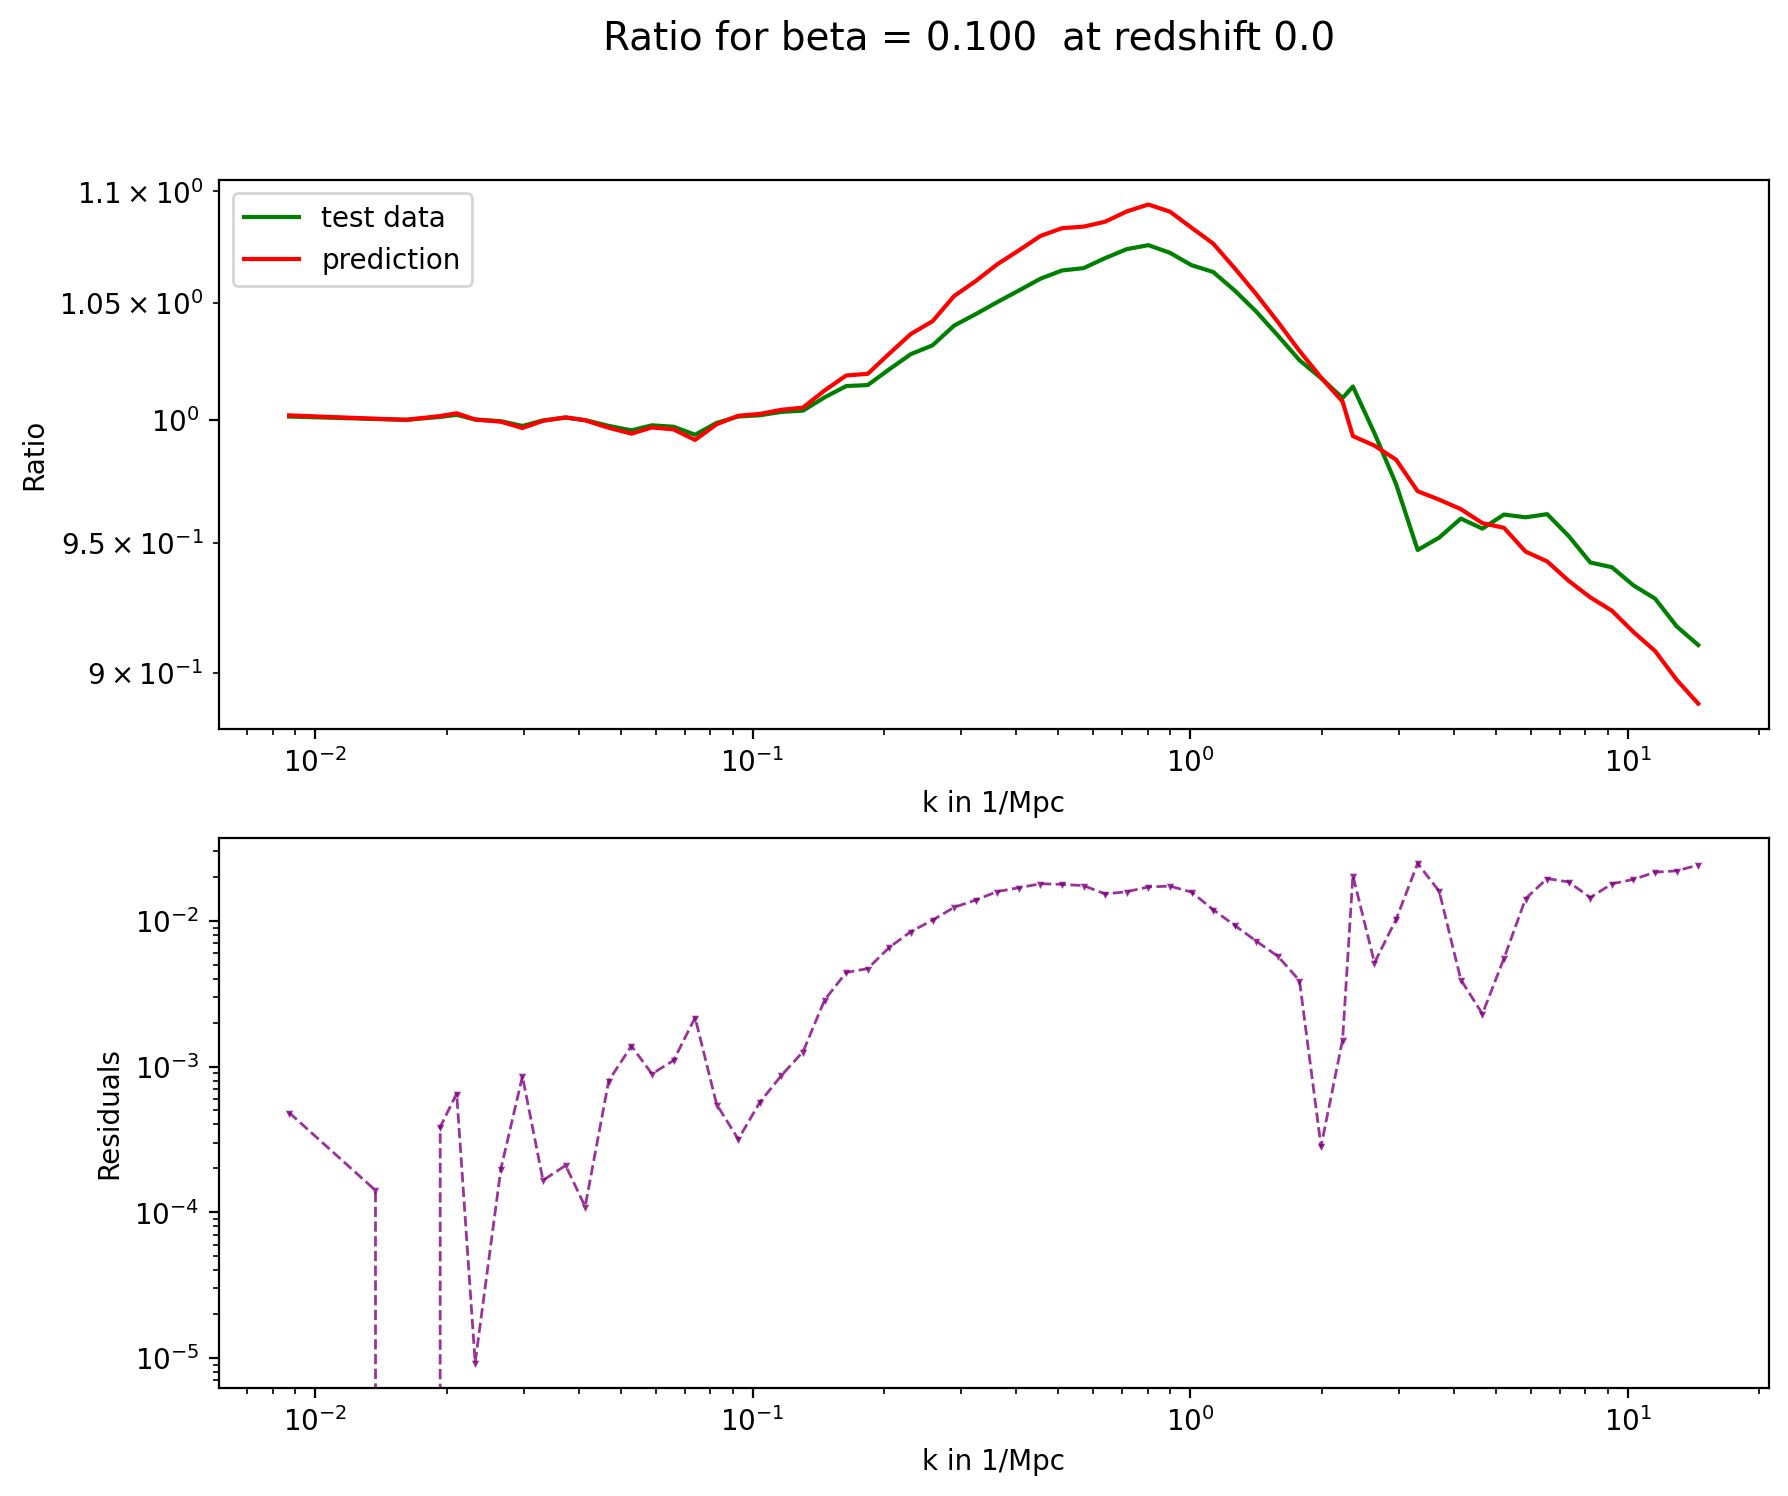

In [140]:
pm.Plot_prediction_One_parameter(emulation_data, 0.098,ratios_predicted_PCAspl, y_scale_log=True);

The user can select one of the test parameter values to plot the spectrum against the emulator prediction. If a normalisation of ratios have been carried out, it can perform an interpolation of the normalisation factor first before reconstructing the data.

In [110]:
resipred_beta_PCAspl = np.abs(((ratios_predicted_PCAspl[(0.1),]-emulation_data.matrix_datalearn_dict['theo']['test'].flatten())/emulation_data.matrix_datalearn_dict['theo']['test'].flatten()))

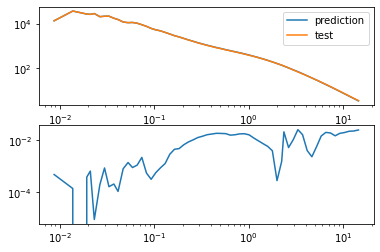

In [111]:
fig,ax  = plt.subplots(2,1)
df_kgrid = emulation_data.df_ref.loc['k_grid'].values.flatten()
n_pred = ratios_predicted_PCAspl[(0.1,)]
n_test = emulation_data.matrix_datalearn_dict['theo']['test'].flatten()
df_ref_pk = emulation_data.df_ref.loc['theo',0.0].values.flatten()
ax[0].loglog(df_kgrid, df_ref_pk*n_pred, label='prediction')
ax[0].loglog(df_kgrid, df_ref_pk*n_test, label='test')
ax[0].legend()
ax[1].loglog(df_kgrid, resipred_beta_PCAspl)

In [151]:
normalized_pred_ratio = np.column_stack((df_kgrid, n_test))
np.savetxt('./obs_data/ratio-Codecs-website-truth-norm-beta0p1-z0.txt', normalized_pred_ratio)

In [91]:
#reconstructed_spectra = dcl.reconstruct_spectra(ratios_predicted,emulation_data = emulation_data,
#                                                normalization=False)
                                            
#pm.Plot_prediction_One_parameter(emulation_data, 0.1 , reconstructed_spectra,
#                                 ratio_mode=False, ## False when the user wants to reconstruct the spectra 
#                                 y_scale_log=True) ## y_scale in log 

# DL with GP interpolation

The following section performs first a sparse representation of the data **with dictionary learning** and construct the **interpolation with a Gaussian Process**. Note that the level of noise for the GP's kernel should be chosen carefully.

In [123]:
npca = 6

In [124]:
train_redshift_indices= [1]
test_redshift_indices= [1] 

In [125]:
emulation_data.z_requested

array([0.])

In [126]:
ratios_predicted_DL , emulation_data = dcl.Predict_ratio(emulation_data,Operator ="DL",
                                                      train_noise = 1e-10, ##noise for the GP's kernel
                                                      gp_n_rsts = 10,##times allowed to restart the optimiser
                                                      ncomp=npca , ##number of components
                                                      gp_const = 1, ##Constant for the RBF kernel
                                                      gp_length = 1, ## Length for  GP 
                                                      interp_type='GP', ##kind of interpolator,e.g int1d or GP 
                                                      n_splits = 1, ##number of splits
                                                      test_indices=test_indices)

('Shape of DL matrix: (2, 6)',)
('Number of DL components: 6',)


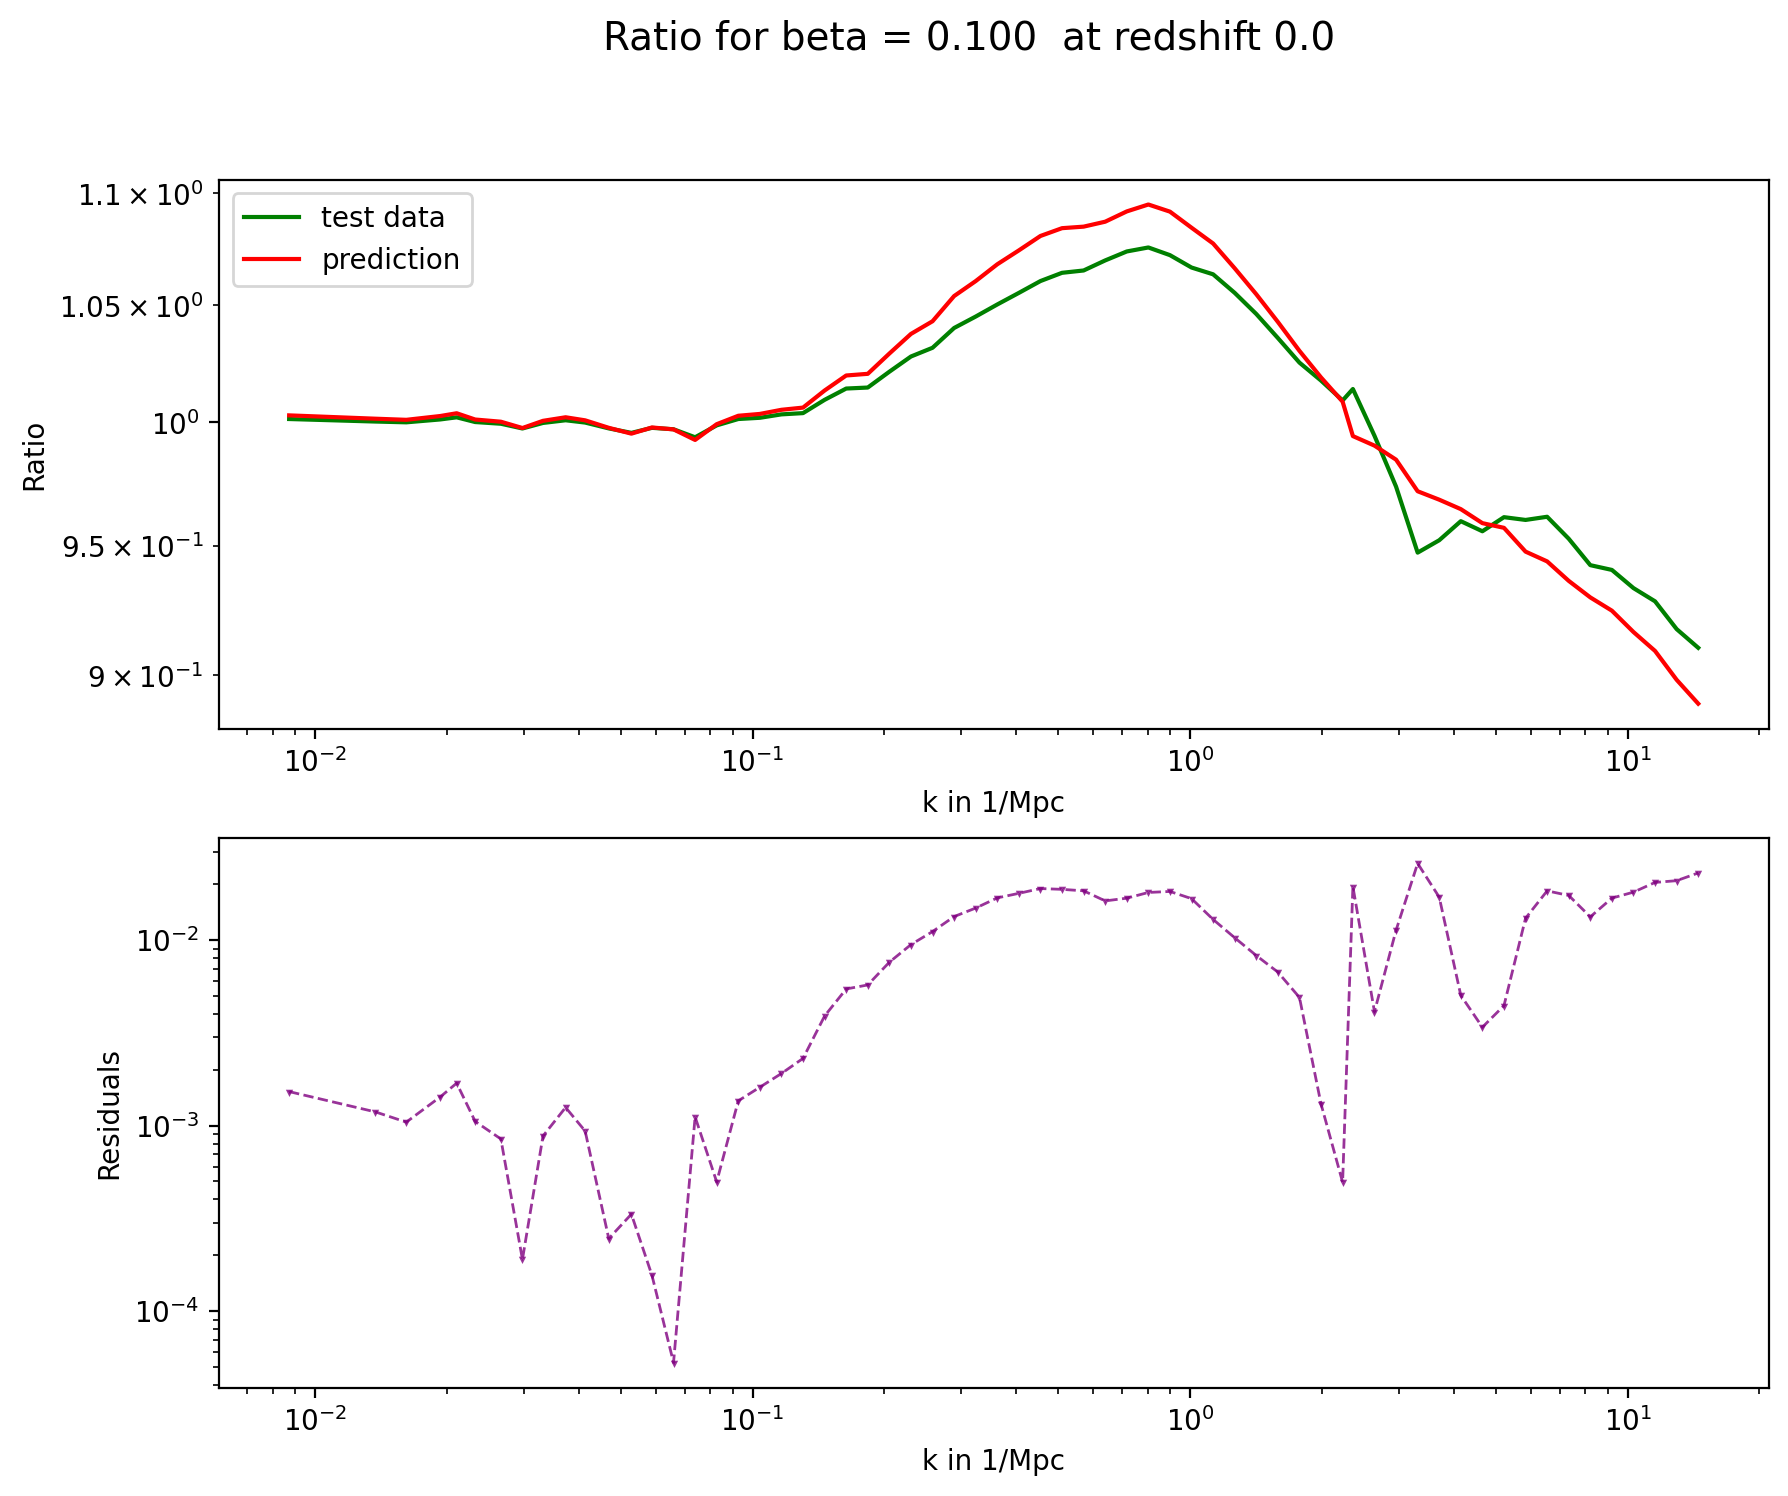

In [127]:
pm.Plot_prediction_One_parameter(emulation_data, 0.098 , ratios_predicted_DL, y_scale_log=True);

In [128]:
resipred_beta_DL = np.abs(((ratios_predicted_DL[(0.1),]-emulation_data.matrix_datalearn_dict['theo']['test'].flatten())/emulation_data.matrix_datalearn_dict['theo']['test'].flatten()))

In [92]:
#reconstructed_spectra = dcl.reconstruct_spectra(ratios_predicted,emulation_data = emulation_data,normalization=False)
#pm.Plot_prediction_One_parameter(emulation_data, 0.098 , reconstructed_spectra,ratio_mode=False,y_scale_log=True)

#  PCA with GP interpolation

The following section performs a **reduction of dimensionality with PCA** and construct the **interpolation with a Gaussian Process**. Note that the level of noise for the GP's kernel should be chosen carefully.

In [152]:
npca = 2

In [153]:
ratios_predicted_PCAgp , emulation_data, interpolFunction_PCAgp = dcl.Predict_ratio(emulation_data,Operator = "PCA",
                                                      train_noise = 1e-7, ##noise for the GP's kernel
                                                      gp_n_rsts = 10,##times allowed to restart the optimiser
                                                      ncomp=npca , ##number of components
                                                      gp_const = 1, ##Constant for the RBF kernel
                                                      gp_length = 1, ## Length for  GP 
                                                      interp_type='GP', ##kind of interpolator,e.g int1d or GP 
                                                      n_splits = 1, ##number of splits
                                                      test_indices=test_indices,
                                                    return_interpolator=True)

('Shape of PCA matrix: (2, 2)',)
('Number of PCA components: 2',)


In [158]:
from looti import interpolatingObject as ito

In [159]:
Interpolation = ito.Interpolating_function()

In [176]:
function = ito.Interpolating_function_redshift (emulation_data,interpolFunction_PCAgp,0.,normalize=False)

In [186]:
function

In [178]:
function.predict(0.9,0.1)  #df_kgrid

1.0906014120345338

In [179]:
df_kgrid

array([8.71613e-03, 1.37303e-02, 1.61497e-02, 1.93063e-02, 2.10518e-02,
       2.32049e-02, 2.65655e-02, 2.97616e-02, 3.31624e-02, 3.73538e-02,
       4.13976e-02, 4.68828e-02, 5.28083e-02, 5.88426e-02, 6.59221e-02,
       7.38534e-02, 8.27388e-02, 9.26934e-02, 1.03846e-01, 1.16339e-01,
       1.30337e-01, 1.46018e-01, 1.63585e-01, 1.83267e-01, 2.05316e-01,
       2.30018e-01, 2.57692e-01, 2.88696e-01, 3.23430e-01, 3.62342e-01,
       4.05936e-01, 4.54776e-01, 5.09491e-01, 5.70789e-01, 6.39462e-01,
       7.16397e-01, 8.02589e-01, 8.99150e-01, 1.00733e+00, 1.12852e+00,
       1.26430e+00, 1.41641e+00, 1.58682e+00, 1.77774e+00, 1.99162e+00,
       2.23124e+00, 2.35527e+00, 2.63864e+00, 2.95610e+00, 3.31176e+00,
       3.71020e+00, 4.15658e+00, 4.65667e+00, 5.21693e+00, 5.84459e+00,
       6.54777e+00, 7.33555e+00, 8.21811e+00, 9.20685e+00, 1.03145e+01,
       1.15555e+01, 1.29458e+01, 1.45033e+01])

In [180]:
funcpred=[function.predict(kii,0.1) for kii in (df_kgrid)]

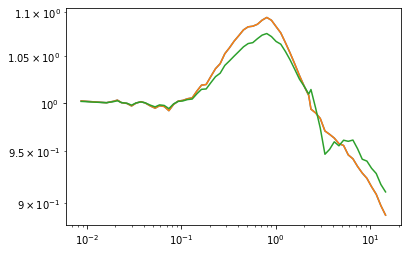

In [185]:
plt.loglog(df_kgrid, funcpred)
plt.loglog(df_kgrid, ratios_pred_testa)
plt.loglog(df_kgrid, n_test)

In [188]:
import joblib

In [189]:
filename='../interpolating_objects/CDE_ratio-Codecs_Website-z0-interpObj.sav'
with open(filename, 'wb') as f:
    joblib.dump(function, f)

In [183]:
ratios_pred_testa=np.array([1.00185703, 1.00046657, 1.        , 1.00158469, 1.00273955,
        1.00012578, 0.99921293, 0.99658552, 0.99958089, 1.00106474,
        0.99978816, 0.99667225, 0.99424674, 0.99681825, 0.99602066,
        0.99164597, 0.99818054, 1.00169389, 1.00246095, 1.00418864,
        1.00510846, 1.0122975 , 1.01865312, 1.01936199, 1.02801548,
        1.03645844, 1.04194774, 1.05294709, 1.05953983, 1.06698957,
        1.07319028, 1.0796569 , 1.083172  , 1.08386216, 1.08609741,
        1.09076275, 1.09391043, 1.09065859, 1.08338096, 1.07627112,
        1.06521181, 1.05374042, 1.04165313, 1.02916166, 1.01781867,
        1.0075957 , 0.99324095, 0.98930277, 0.98352971, 0.97066359,
        0.96725684, 0.96345551, 0.95784203, 0.95596821, 0.94653991,
        0.9426908 , 0.93506727, 0.92864004, 0.92350791, 0.9153322 ,
        0.90813369, 0.89728069, 0.88839529])

(array([1.00137417, 1.00032538, 1.        , 1.00119988, 1.00208663,
        1.0001165 , 0.99941046, 0.99744012, 0.99974639, 1.0008551 ,
        0.99989739, 0.99747097, 0.99562265, 0.99770671, 0.99711746,
        0.99379722, 0.99872794, 1.0013763 , 1.0018914 , 1.00331674,
        1.00384084, 1.00940703, 1.01416844, 1.01459165, 1.02129815,
        1.0277846 , 1.03152849, 1.04006353, 1.04503076, 1.05030007,
        1.05537958, 1.06059142, 1.06423781, 1.06527084, 1.06974283,
        1.07374344, 1.07552833, 1.07209748, 1.06658177, 1.06357365,
        1.05539018, 1.04614726, 1.03573654, 1.02517201, 1.01753108,
        1.00913834, 1.01397842, 0.99442638, 0.97357893, 0.94718411,
        0.9520834 , 0.95967016, 0.95564627, 0.96127702, 0.96016769,
        0.96143906, 0.95268326, 0.94225475, 0.94038828, 0.93329961,
        0.92816724, 0.91750162, 0.91037896]),
 array([1.00185703, 1.00046657, 1.        , 1.00158469, 1.00273955,
        1.00012578, 0.99921293, 0.99658552, 0.99958089, 1.00106474,
  

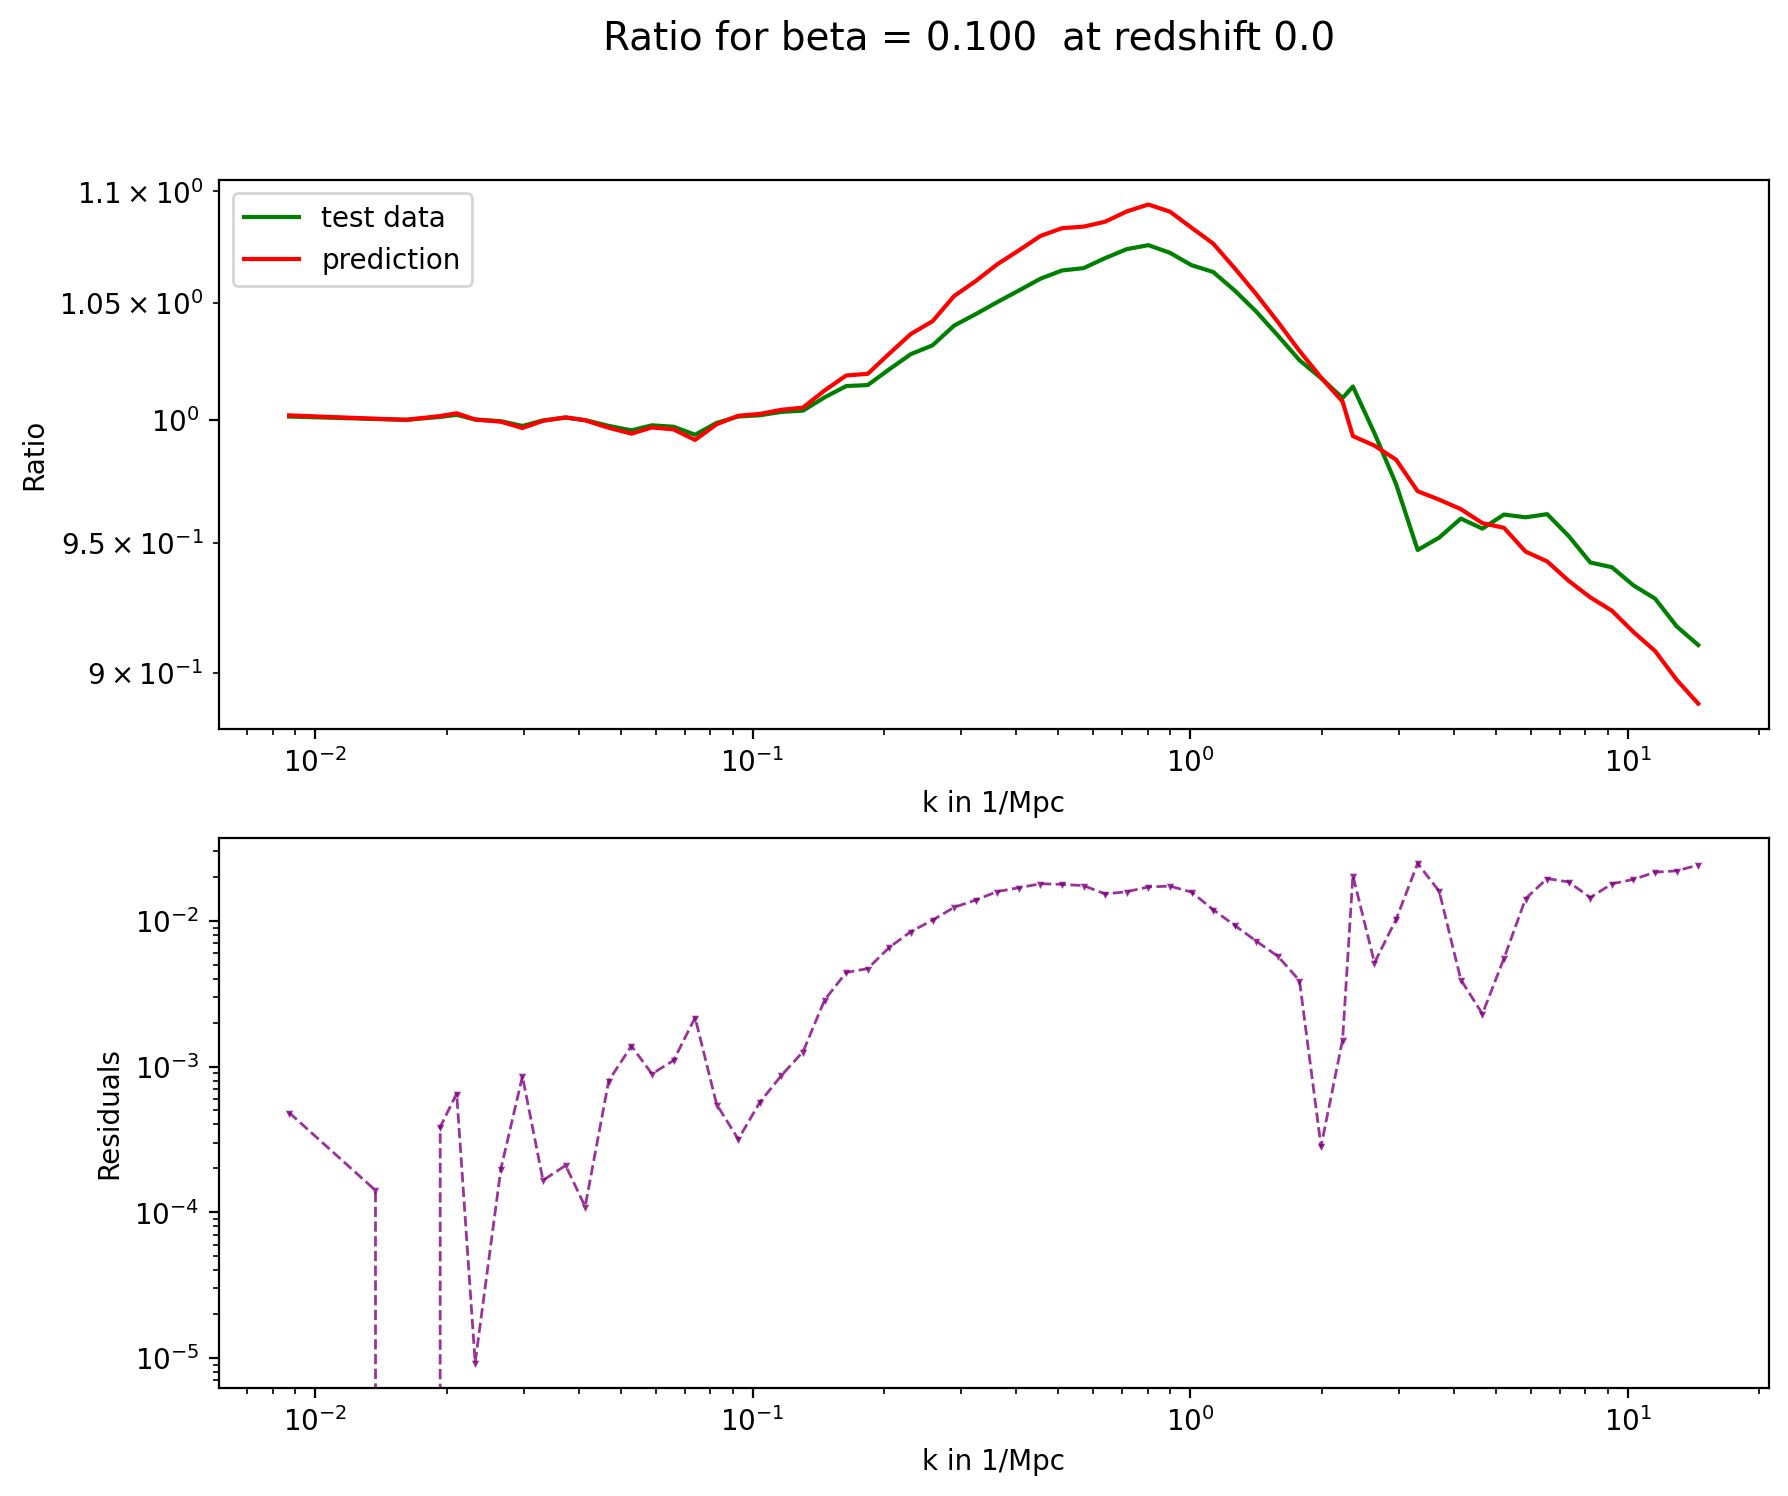

In [117]:
pm.Plot_prediction_One_parameter(emulation_data, 0.098 , ratios_predicted_PCAgp, y_scale_log=True)

In [118]:
resipred_beta_PCAgp = np.abs(((ratios_predicted_PCAgp[(0.1),]-emulation_data.matrix_datalearn_dict['theo']['test'].flatten())/emulation_data.matrix_datalearn_dict['theo']['test'].flatten()))

In [100]:
#reconstructed_spectra = dcl.reconstruct_spectra(ratios_predicted,emulation_data = emulation_data,normalization=True)
#pm.Plot_prediction_One_parameter(emulation_data, 0.098 , reconstructed_spectra,ratio_mode=False,y_scale_log=True)

# GP Example

The following section performs construct the **interpolation with a Gaussian Process**. Note that the level of noise for the GP's kernel should be chosen carefully.

In [119]:
ratios_predicted_GP , emulation_data = dcl.Predict_ratio(emulation_data,Operator = "GP",
                                                      train_noise = 1e-7, ##noise for the GP's kernel
                                                      gp_n_rsts = 10,##times allowed to restart the optimiser
                                                      ncomp=npca , ##number of components
                                                      gp_const = 1, ##Constant for the RBF kernel
                                                      gp_length = 1 , ## Length for  GP 
                                                      interp_type='GP', ##kind of interpolator,e.g int1d or GP 
                                                      n_splits = n_splits, ##number of splits
                                                      test_indices=test_indices)#indices of the reshift used for test 

(array([1.00137417, 1.00032538, 1.        , 1.00119988, 1.00208663,
        1.0001165 , 0.99941046, 0.99744012, 0.99974639, 1.0008551 ,
        0.99989739, 0.99747097, 0.99562265, 0.99770671, 0.99711746,
        0.99379722, 0.99872794, 1.0013763 , 1.0018914 , 1.00331674,
        1.00384084, 1.00940703, 1.01416844, 1.01459165, 1.02129815,
        1.0277846 , 1.03152849, 1.04006353, 1.04503076, 1.05030007,
        1.05537958, 1.06059142, 1.06423781, 1.06527084, 1.06974283,
        1.07374344, 1.07552833, 1.07209748, 1.06658177, 1.06357365,
        1.05539018, 1.04614726, 1.03573654, 1.02517201, 1.01753108,
        1.00913834, 1.01397842, 0.99442638, 0.97357893, 0.94718411,
        0.9520834 , 0.95967016, 0.95564627, 0.96127702, 0.96016769,
        0.96143906, 0.95268326, 0.94225475, 0.94038828, 0.93329961,
        0.92816724, 0.91750162, 0.91037896]),
 array([1.00260636, 1.00121486, 1.00074794, 1.00233382, 1.00348954,
        1.00087382, 0.99996028, 0.99733091, 1.00032852, 1.00181348,
  

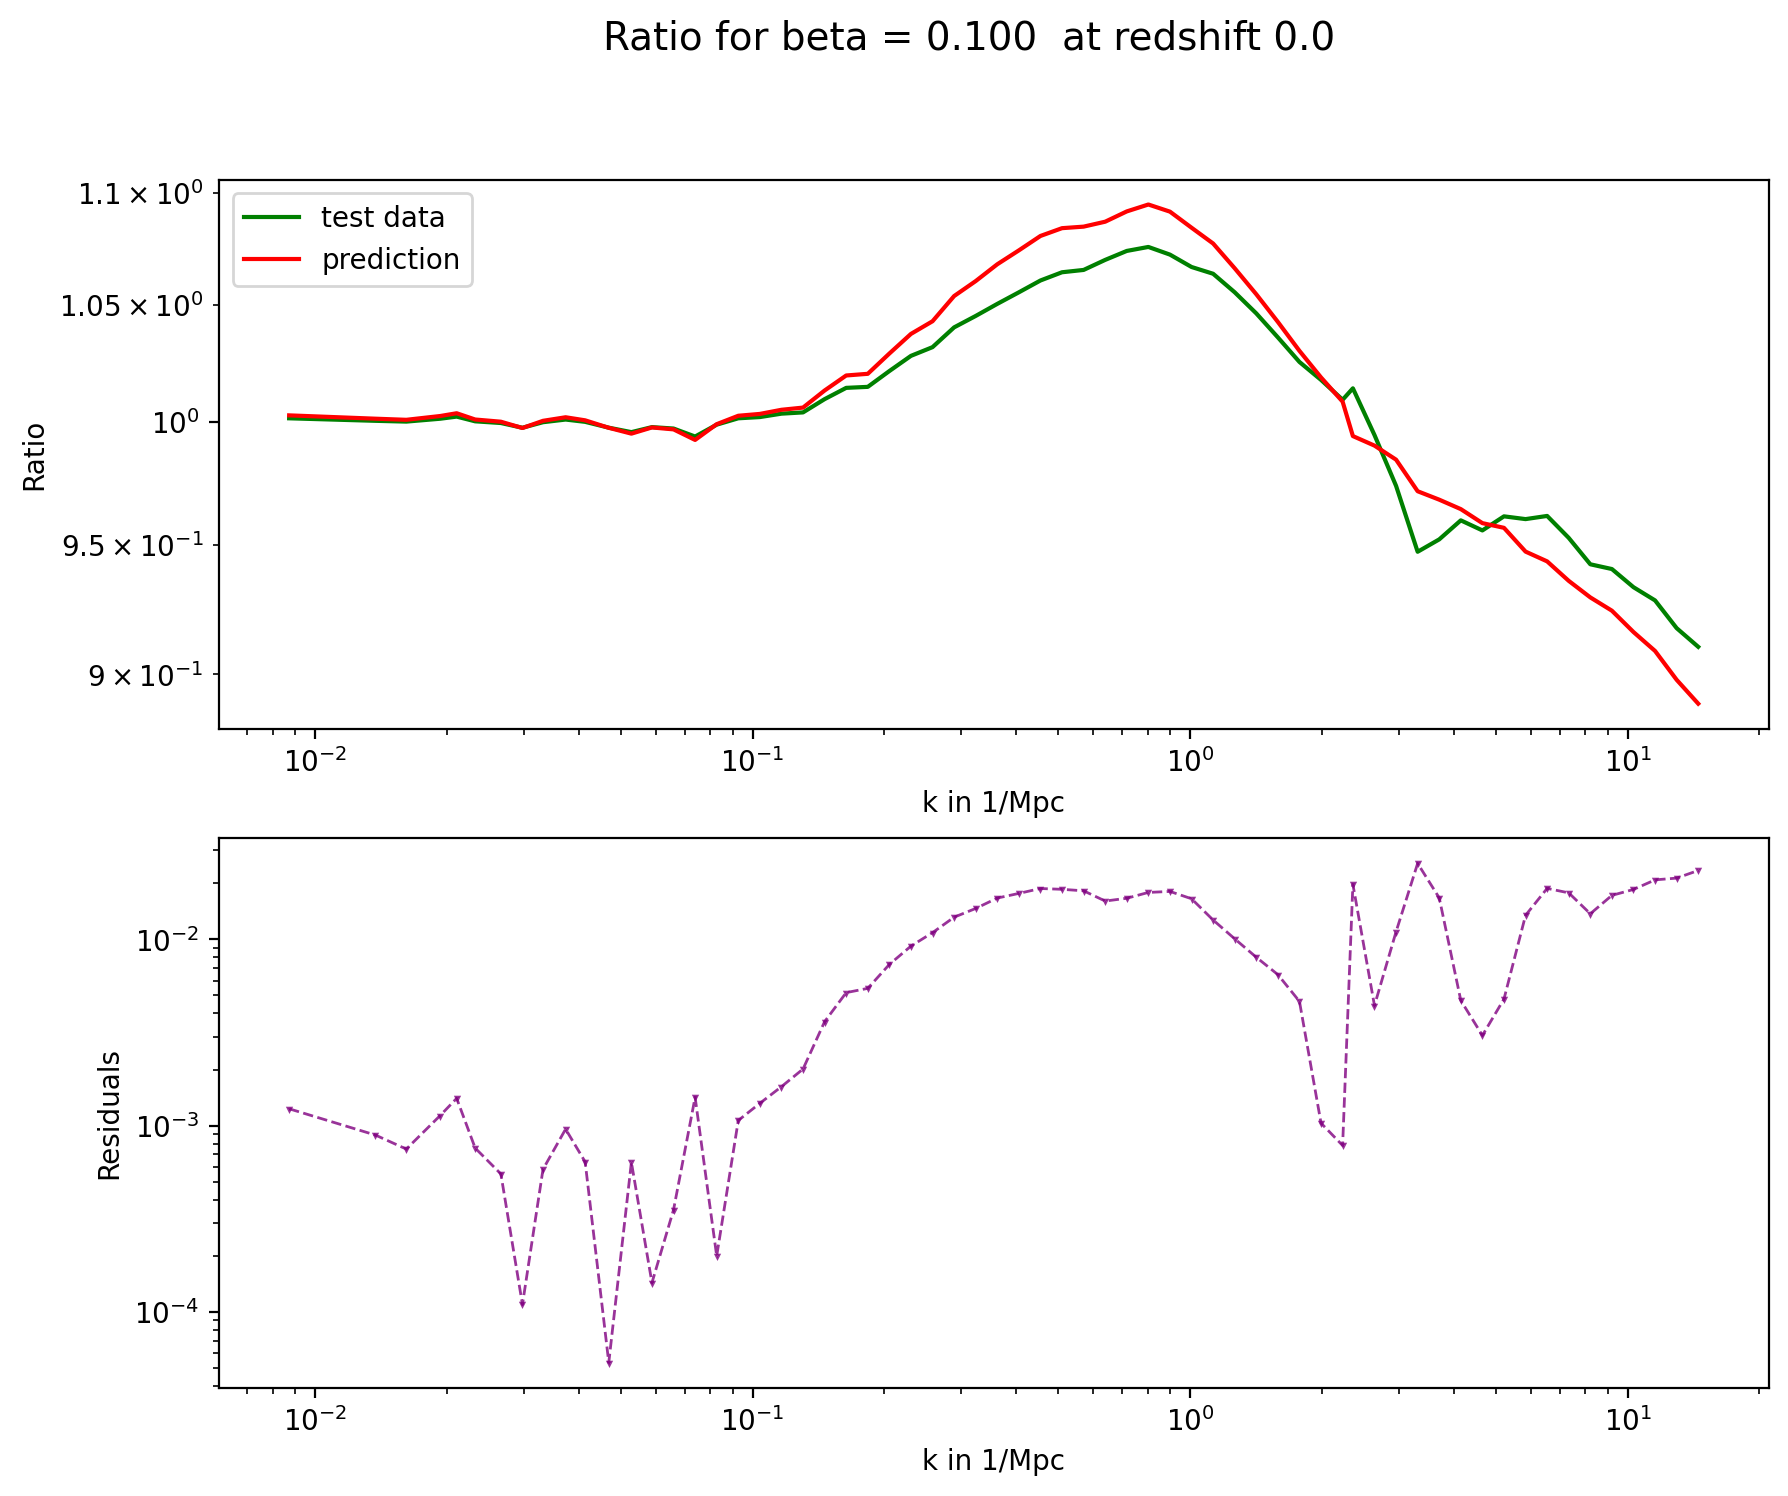

In [120]:
pm.Plot_prediction_One_parameter(emulation_data, 0.098,ratios_predicted_GP, y_scale_log=True)

In [121]:
resipred_beta_GP = np.abs(((ratios_predicted_GP[(0.1),]-emulation_data.matrix_datalearn_dict['theo']['test'].flatten())/emulation_data.matrix_datalearn_dict['theo']['test'].flatten()))

In [104]:
#reconstructed_spectra = dcl.reconstruct_spectra(ratios_predicted,emulation_data = emulation_data,normalization=True)
#pm.Plot_prediction_One_parameter(emulation_data, 0.098 , reconstructed_spectra,ratio_mode=False,y_scale_log=True)

Text(0, 0.5, 'absolute residuals')

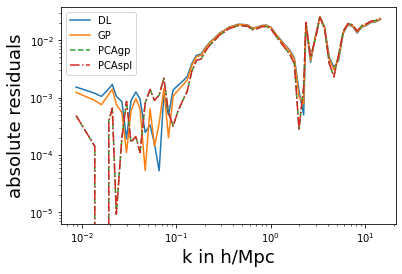

In [150]:
plt.loglog(df_kgrid, resipred_beta_DL, label='DL')
plt.loglog(df_kgrid,resipred_beta_GP, label='GP')
plt.loglog(df_kgrid,resipred_beta_PCAgp, label='PCAgp', ls='--')
plt.loglog(df_kgrid,resipred_beta_PCAspl, label='PCAspl', ls='-.')
plt.legend()
plt.xlabel("k in h/Mpc", fontsize=18)
plt.ylabel("absolute residuals", fontsize=18)